In [1]:
import random
from prediction_analysis import analyze_data
from getting_examples import get_activation_data_for_feature
from predict_activations import predict_activations
import concurrent.futures

l1s [0.4109407365558629, 0.414493159959613, 0.48951528047608617, 0.5695020958336744, 0.6124067520499359, 0.6165705909820729, 0.6361100537627227, 0.648160706849041, 0.7847868242263788, 0.8494874927572491]


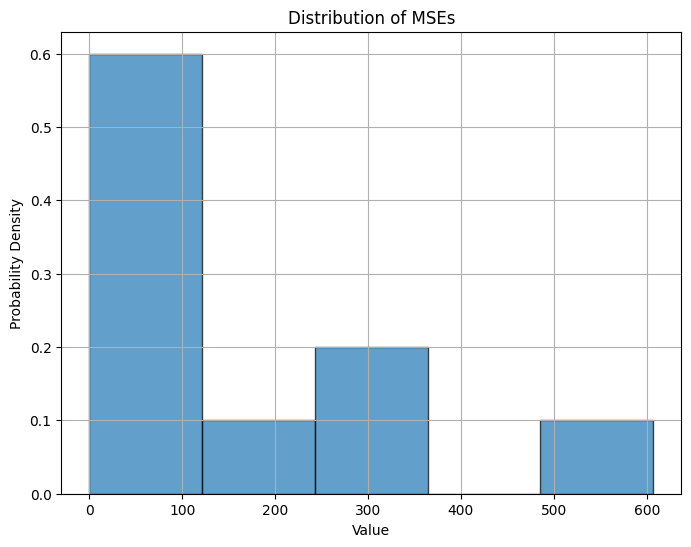

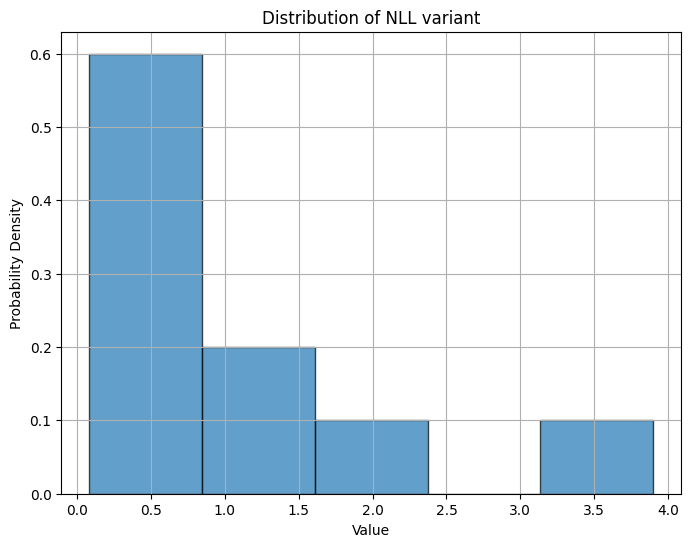

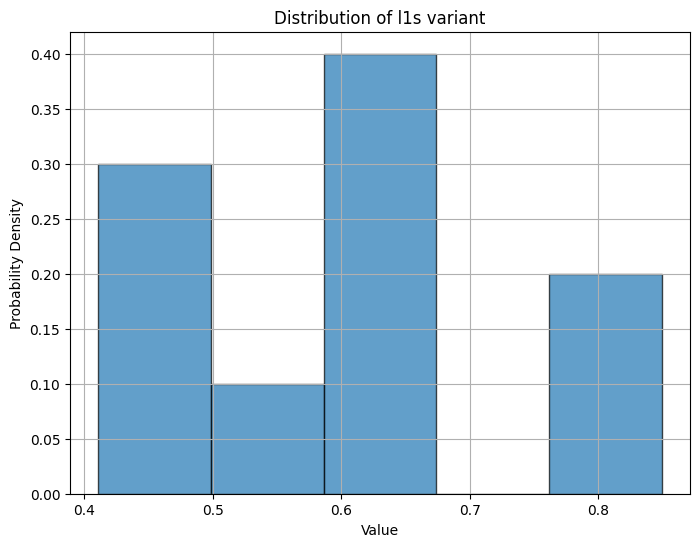

In [2]:
feature_nums = random.sample(range(0, 1000), 10)

def get_predictions(feature_num):
    # activation_data = get_activation_data_for_feature(f"https://www.neuronpedia.org/api/feature/gpt2-small/9-res-jb/{feature_num}")
    predictions = predict_activations(feature_num, test_number=10, show_examples=8)
    return predictions


with concurrent.futures.ThreadPoolExecutor() as executor:
    all_data = list(executor.map(get_predictions, feature_nums))

analyze_data(all_data)

[0.463876505737998, 0.5235644681417371, 0.8587576743701637, 0.8866750601083888, 0.9125656661489081, 0.9186451233616489, 1.083695968364533, 1.1914572527696126, 1.3683799786247806, 1.629129639383174]


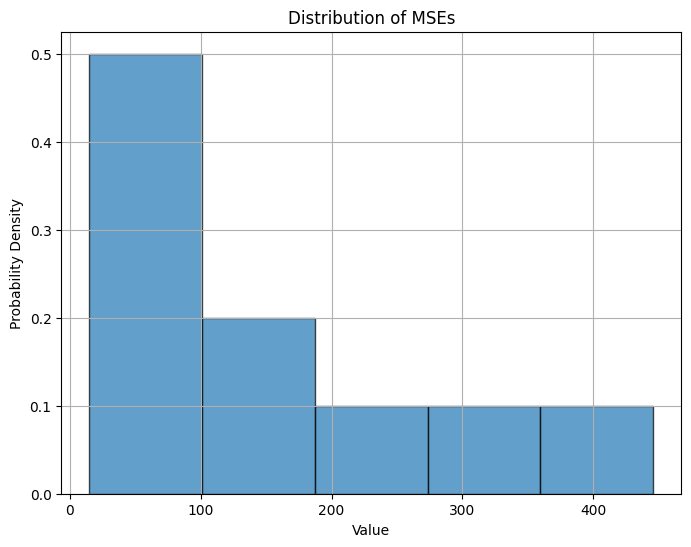

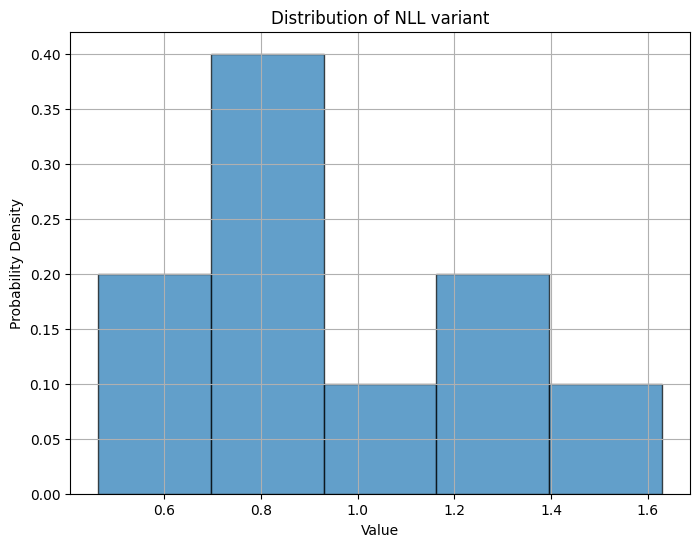

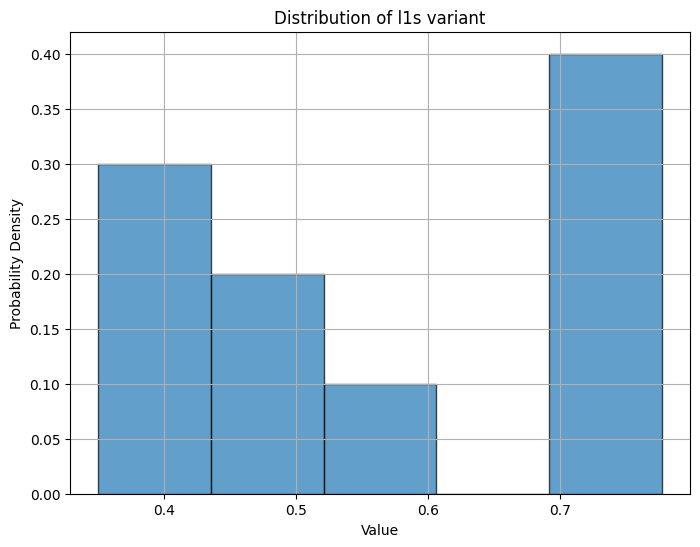

In [10]:
analyze_data(all_data)